In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix
import geopandas as gpd
import contextily as ctx
from plottable import Table, ColumnDefinition
from highlight_text import fig_text

In [2]:
scottish_munros = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-08-19/scottish_munros.csv", encoding = "latin")

In [3]:
scottish_munros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DoBIH_number  604 non-null    object 
 1   Name          603 non-null    object 
 2   Height_m      603 non-null    float64
 3   Height_ft     603 non-null    float64
 4   xcoord        603 non-null    float64
 5   ycoord        603 non-null    float64
 6   1891          538 non-null    object 
 7   1921          543 non-null    object 
 8   1933          543 non-null    object 
 9   1953          543 non-null    object 
 10  1969          543 non-null    object 
 11  1974          541 non-null    object 
 12  1981          517 non-null    object 
 13  1984          517 non-null    object 
 14  1990          517 non-null    object 
 15  1997          511 non-null    object 
 16  2021          508 non-null    object 
 17  Comments      283 non-null    object 
dtypes: float64(4), object(14)
memo

In [4]:
scottish_munros.head(2)

,DoBIH_number,Name,Height_m,Height_ft,xcoord,ycoord,1891,1921,1933,1953,1969,1974,1981,1984,1990,1997,2021,Comments
0,1,Ben Chonzie,931.0,3054.0,277324.0,730857.0,Munro,Munro,Munro,Munro,Munro,Munro,Munro,Munro,Munro,Munro,Munro,NaN
1,17,Ben Vorlich,985.3,3233.0,262912.0,718916.0,Munro,Munro,Munro,Munro,Munro,Munro,Munro,Munro,Munro,Munro,Munro,NaN


In [5]:
# Select relevant data and setting index for the distance matrix
df = scottish_munros[["Name", "xcoord", "ycoord"]].set_index("Name")

In [6]:
df = df.dropna()

In [7]:
# Distance matrix in km
dm = pd.DataFrame(distance_matrix(df.values/1000, df.values/1000), index=df.index, columns=df.index)

In [8]:
dm.head(2)

Name,Ben Chonzie,Ben Vorlich,Stuc a' Chroin,Ben Lomond,Ben More,Stob Binnein,Stob Binnein - Stob Coire an Lochain,Stob Binnein - Creag a' Bhragit,Stob Binnein - Meall na Dige,Cruach Ardrain,...,Sgurr Mhic Choinnich,Sgurr Alasdair,Sgurr Alasdair - Sgurr Thearlaich,Sgurr Alasdair - Sgurr Sgumain,Sgurr Dubh Mor,Sgurr Dubh Mor - Sgurr Dubh an Da Bheinn,Sgurr nan Eag,Blabheinn [Bla Bheinn],Blabheinn South Top,Ben More
Name,,,,,,,,,,,,,,,,,,,,,
Ben Chonzie,0.000000,18.716122,20.543119,49.329552,34.651694,34.809333,34.620404,33.542970,33.314513,37.652487,...,160.118278,159.988520,159.923418,160.055816,159.229107,159.377184,158.705785,154.010417,153.993323,124.767770
Ben Vorlich,18.716122,0.000000,1.861439,30.731105,20.391996,19.798318,19.326132,18.410892,18.235358,22.104878,...,155.975792,155.820812,155.760694,155.867058,155.093262,155.216742,154.472863,150.519892,150.472493,111.241158


In [9]:
# Remove self distances
for name in dm.index:
    dm.loc[name, name] = float('nan')

# Nearest Munro name and distance
df['nearest_munro'] = dm.idxmin(axis=1)
df['nearest_dist'] = dm.min(axis=1)

In [10]:
# Convert to geo dataframe
munros_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["xcoord"], df["ycoord"]),
    crs="EPSG:27700"  
)

In [11]:
# Create bins for distance and color
bins = [0, 5, 10, 20, 30, munros_gdf["nearest_dist"].max()]
labels = ["0–5 km", "5–10 km", "10–20 km", "20–30 km", "30+ km"]
munros_gdf["remoteness_bin"] = pd.cut(munros_gdf["nearest_dist"], bins=bins, labels=labels)

In [12]:
munros_gdf["remoteness_bin"].value_counts()

remoteness_bin
0–5 km      590
5–10 km       7
10–20 km      3
20–30 km      2
30+ km        1
Name: count, dtype: int64

In [13]:
# Colors
color_mapping = {
    "0–5 km": "black",     
    "5–10 km": "#744ADA", #purple
    "10–20 km": "#D0B939", # yellow
    "20–30 km": "#F65200", # orange 
    "30+ km":"#BF000B" # red   
}

In [14]:
# Color mapping
munros_gdf["color"] = munros_gdf["remoteness_bin"].map(color_mapping)

In [15]:
# Scotland's boundary
scotland = gpd.read_file("ltla2025.geojson")

In [16]:
# Subset of data where distance is above 10 kms
subset = munros_gdf[munros_gdf["nearest_dist"]>10].reset_index()

In [17]:
# Select data for text table
txt_table = subset[["Name", "nearest_munro", "nearest_dist"]]

In [18]:
# Format text table
txt_table = txt_table.copy()
txt_table = txt_table.sort_values(by="nearest_dist", ascending=False, ignore_index=True)
txt_table["nearest_dist"] = txt_table["nearest_dist"].round(1)

In [19]:
txt_table

,Name,nearest_munro,nearest_dist
0,Ben More,Ben Cruachan - Stob Dearg [Taynuilt Peak],53.7
1,Ben Hope,Ben Klibreck - Meall nan Con,22.9
2,Ben Klibreck - Meall nan Con,Ben Hope,22.9
3,Ben Chonzie,Meall Greigh,16.3
4,Mount Keen,Cac Carn Beag (Lochnagar) - Little Pap,14.7
5,Ben Lomond,Beinn Narnain,10.3


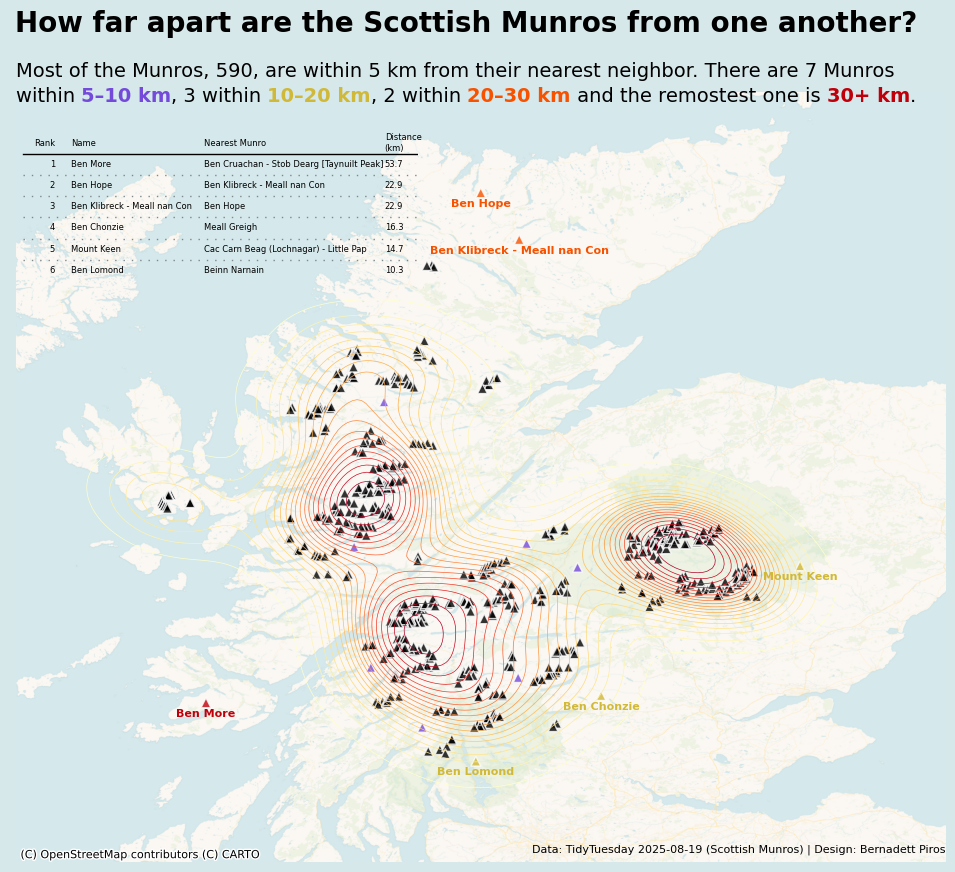

In [20]:
# Contextily requires EPSG:3857
scotland = scotland.to_crs(3857)
munros_gdf = munros_gdf.to_crs(3857)

# Union overlay for boundary and munros
overlay = gpd.overlay(scotland, munros_gdf, how='union', keep_geom_type=False)

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Munros scatter plot 
ax.scatter(
    munros_gdf.geometry.x,
    munros_gdf.geometry.y,
    c=munros_gdf["color"],
    marker="^",
    edgecolor="white",
    s=50,     
    alpha=0.8
)

contour_kws={'linewidths': 0.5}

# KDE with seaborn 
x = munros_gdf.geometry.x
y = munros_gdf.geometry.y
sns.kdeplot(
    x=x,
    y=y,
    ax=ax,
    cmap="YlOrRd",    
    levels=20,    
    **contour_kws
)

subset = munros_gdf[munros_gdf["nearest_dist"]>10].reset_index()
# Iterate over rows in the subset dataframe
for i, row in subset.iterrows():
    munro = row["Name"]  
    x_value = row.geometry.x  
    y_value = row.geometry.y  
    
    # Add text annotations 
    ax.text(
        x=x_value,
        y=y_value-5000,
        s=munro,  
        fontsize=8,
        weight="bold",
        ha='center',  
        va="top",
        c=row["color"]  
    )

# Add basemap 
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, zoom=10)

ax.axis("off")

# Child ax for text table
inset_ax = fig.add_axes([0.13, 0.69, 0.33, 0.15]) 
inset_ax.axis("off")
inset_ax.patch.set_alpha(0)

txt_table['Rank'] = txt_table.index+1
txt_table = txt_table.set_index("Rank")

# Text table with plottable
tab = Table(
    txt_table,
    ax=inset_ax,
    cell_kw={
        "linewidth": 0,
        "edgecolor": "#010101",
    },    
    textprops={"fontsize": 6, "color": "#010101"},
    column_definitions=[
        ColumnDefinition(
            "index",
            title="Rank",
            textprops={"ha": "left"},
            width=0.05),           
        ColumnDefinition(
            "Name",
            title="Name",
            textprops={"ha": "left"},
            width=3.5),
        ColumnDefinition(
            "nearest_munro",
            title="Nearest Munro",
            textprops={"ha": "left"},
            width=5.5),
        ColumnDefinition(
            "nearest_dist",
            title="Distance\n(km)",
            textprops={"ha":"left"},
            width=1),        
    ],
    row_divider_kw={"linewidth": 1,
                    "linestyle": (0, (1, 5)),
                    "color": "#7f888a",},
    col_label_divider=True
)

# Texts
fig.text(0.5, 0.94, "How far apart are the Scottish Munros from one another?", size=20, weight="bold", ha="center")

fig_text(0.5, 0.91, "Most of the Munros, 590, are within 5 km from their nearest neighbor. There are 7 Munros\nwithin <5–10 km>, 3 within <10–20 km>, 2 within <20–30 km> and the remostest one is <30+ km>.",
         size=14, ha="center",
         highlight_textprops=[
            {"color": color_mapping["5–10 km"], "weight": "bold"},
            {"color": color_mapping["10–20 km"], "weight": "bold"},
            {"color": color_mapping["20–30 km"], "weight": "bold"},
            {"color": color_mapping["30+ km"], "weight": "bold"},                       
            ])

fig.text(0.9, 0.12, "Data: TidyTuesday 2025-08-19 (Scottish Munros) | Design: Bernadett Piros", size=8, ha="right")

fig.set_facecolor("#d7e8eb")

plt.show()

#fig.savefig("2025-08-19.png", bbox_inches='tight', pad_inches=0.2)